 ### INITIALIZATION OF WORKSPACE

In [1]:
import numpy as np
from scipy.spatial import distance
import pylab as pl
%pylab --no-import-all inline
import openturns as ot
from math import sqrt, sin, pi
import matplotlib.pyplot as plt
from Tools import fsm
from Tools import EWIS_func
from Tools.ViewPDF import*

Populating the interactive namespace from numpy and matplotlib


### INPUT DATA

#### Initialisation

In [2]:
Configuration= {}
Configuration['Scenario1'] = {'X_EPDC2':[10, 2, 0], 'V0':28, 'DeltaV':1, 'C1':1.2, 'C2':1.4, 'Workdir':'./Scenario1'}
Configuration['Scenario2'] = {'X_EPDC2':[28, 2, 0], 'V0':28, 'DeltaV':1, 'C1':1.2, 'C2':1.4, 'Workdir':'./Scenario2'}
Conf = Configuration['Scenario2']

In [3]:
# Data Gauge catalog
Catalog_Gauge = np.loadtxt('./Data/Catalog_gauge.csv', delimiter=';').reshape(17,4)[:,1:]

# Positions SPDB, VU
X_SPDB = [[20, 2, 2], [25, 2, 2], [30,2,2], [35,2,2], [40,2,2], [45,2,2], [50,2,2], [55,2,2]]
X_VU   = [[12,0,-2],[14,-2,-2],[14,2,-2]]

#Number of Equipments (PSU Eq for SPDB)
NbPSUBySPDB = 5  
NbPSU       = len (X_SPDB)* NbPSUBySPDB
NbEqByVU    = 15
NbEqVU      = len (X_VU)* NbEqByVU

#### Compute Harness Distance

In [4]:
# Instantiate function with "parameter" X_EPDC2
distance = ot.NumericalMathFunction(EWIS_func.DistanceFunc(Conf['X_EPDC2']))

# Compute lengths for a given EWIS architecture
Dist_SPDB = distance(X_SPDB)
Dist_VU   = distance(X_VU)

### Probabilistic model

#### SPDB

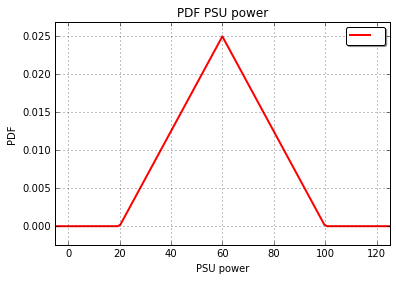

In [5]:
# Marginal law of PSU
distributionMarginal_PSU = ot.Triangular(20.,60.,100.)
viewPDF (distributionMarginal_PSU, 'PDF PSU power', 'PSU power','PDF',' ',Conf['Workdir']+'/PDF PSU.png')

# Independence b/t all PSU
distributionSPDB = ot.ComposedDistribution([distributionMarginal_PSU]*NbPSU)

#### VU

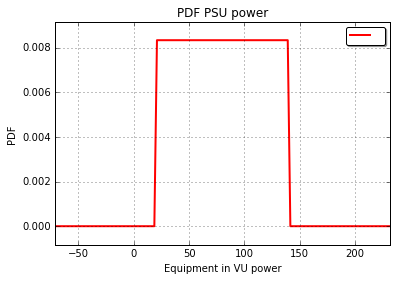

In [6]:
distributionMarginal_Eq = ot.Uniform(20.,140.)
viewPDF (distributionMarginal_Eq,'PDF PSU power', 'Equipment in VU power', 'PDF', ' ', Conf['Workdir']+'/PDF Eq.png')

distributionVU = ot.ComposedDistribution([distributionMarginal_Eq]*(NbEqVU))

### Propagation

#### Generate Sample

In [7]:
sizeSample = 100000
PowerSampleSPDB = distributionSPDB.getSample(sizeSample)
PowerSampleVU   = distributionVU.getSample(sizeSample)

#### Compute Mass & Diameter for SPBD

-------------------------------------------------------------------------------
Mass SPDB 

* ------ Deterministic analysis ------*
Mass SPDB Min = 3.02475 Max =  6.1626 Delta =  3.13785


* ------ Probabilistic analysis ------*
Mass SPDB Quantile @ 5% =  3.6981 Quantile @ 50% =  4.4144 Quantile @ 95% =  5.0072
Mass SPDB: Variance = 0.152271179317 6-sigma =  2.3413163937
Mass SPDB: Interquantile (q(99,7%) - q(0,3%)) =  1.894025
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Diam SPDB 

* ------ Deterministic analysis ------*
Diam SPDB Min = 82.1773 Max =  158.183 Delta =  76.0057


* ------ Probabilistic analysis ------*
Diam SPDB Quantile @ 5% =  101.1107 Quantile @ 50% =  114.5119 Quantile @ 95% =  127.6419
Diam SPDB: Variance = 79.5354910154 6-sigma =  53.5096035918
Diam SPDB: Interquantile (q(99,7%) - q(0,3%)) =  45.0746
--------------------------------------------------

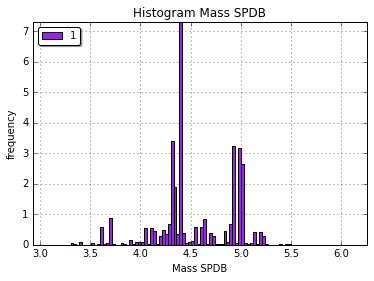

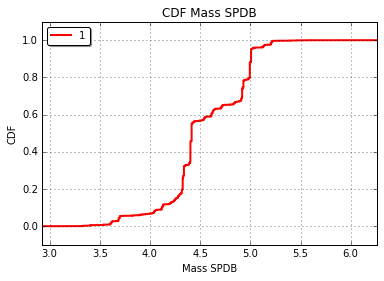

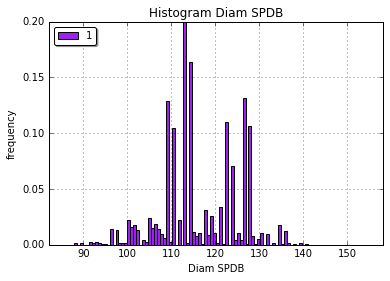

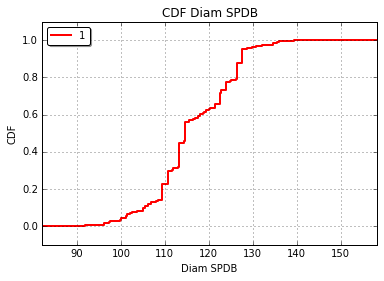

In [8]:
initMassSPDB  = EWIS_func.CalcMassFunc([NbPSUBySPDB, Conf['DeltaV']*Conf['V0']],(np.array(Dist_SPDB))[:,0],Catalog_Gauge)
modelMassSPDB = ot.NumericalMathFunction(initMassSPDB)

Y = modelMassSPDB(PowerSampleSPDB)
#Mass
MassSample_SPDB = Y.getMarginal(0)
MassSPDB_min = MassSample_SPDB.getMin()[0]
MassSPDB_max = MassSample_SPDB.getMax()[0]
fittedDist_Mass_SPDB = ot.KernelSmoothing().build(MassSample_SPDB)

viewResults(MassSample_SPDB, "Mass SPDB", MassSPDB_min-0.1, MassSPDB_max+0.1, Conf['Workdir'])

#Diameter
DiamSample_SPDB = Y.getMarginal(1)
DiamSPDB_min = DiamSample_SPDB.getMin()[0]
DiamSPDB_max = DiamSample_SPDB.getMax()[0]
fittedDist_Diam_SPDB = ot.KernelSmoothing().build(DiamSample_SPDB)

viewResults(DiamSample_SPDB, "Diam SPDB", DiamSPDB_min-0.1, DiamSPDB_max+0.1, Conf['Workdir'])



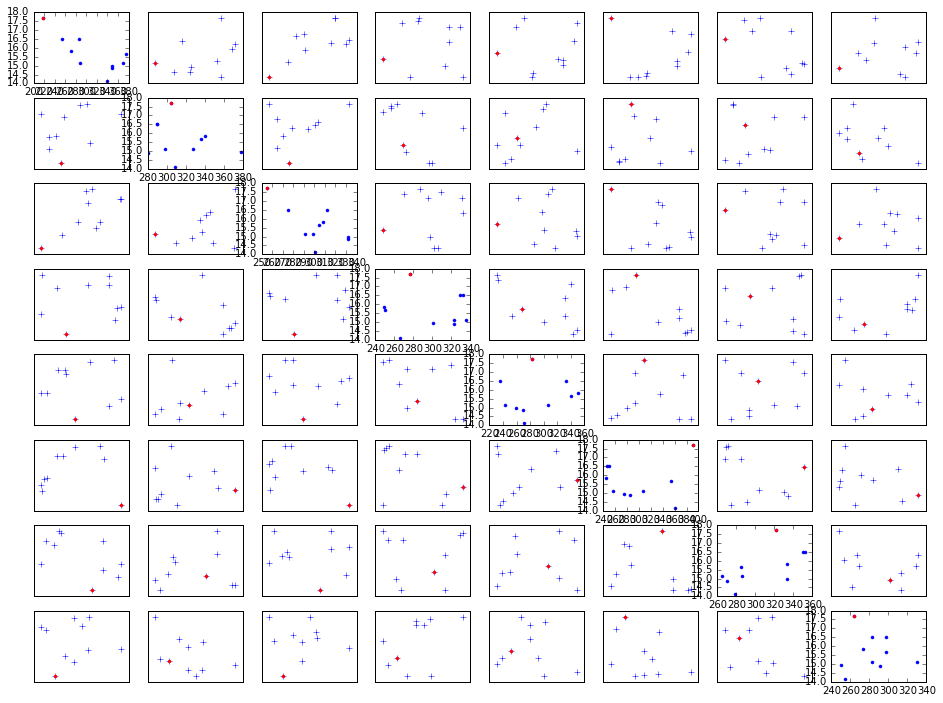

In [11]:
# Visualization of the sum of powers per SPDB vs the total mass of the architecture

R1 = np.array(PowerSampleSPDB).reshape(sizeSample,len(X_SPDB), NbPSUBySPDB)
Sum_Pow_SPDB = R1.sum(axis=2)

v1 =fsm.functional_scatter_matrix(Sum_Pow_SPDB, MassSample_SPDB, ot.GreaterOrEqual(), color="blue", 
                                 values = MassSample_SPDB.computeQuantile(0.99), colors = ["red"])
v1._fig.set_size_inches(16, 12)

#### Compute Mass & Diameter for VU

-------------------------------------------------------------------------------
Mass VU 

* ------ Deterministic analysis ------*
Mass VU Min = 4.7792 Max =  7.3008 Delta =  2.5216


* ------ Probabilistic analysis ------*
Mass VU Quantile @ 5% =  5.264 Quantile @ 50% =  5.7608 Quantile @ 95% =  6.2208
Mass VU: Variance = 0.121551230053 6-sigma =  2.09185187857
Mass VU: Interquantile (q(99,7%) - q(0,3%)) =  1.4968
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Diam VU 

* ------ Deterministic analysis ------*
Diam VU Min = 4.7792 Max =  7.3008 Delta =  2.5216


* ------ Probabilistic analysis ------*
Diam VU Quantile @ 5% =  5.264 Quantile @ 50% =  5.7608 Quantile @ 95% =  6.2208
Diam VU: Variance = 0.121551230053 6-sigma =  2.09185187857
Diam VU: Interquantile (q(99,7%) - q(0,3%)) =  1.4968
-------------------------------------------------------------------------------


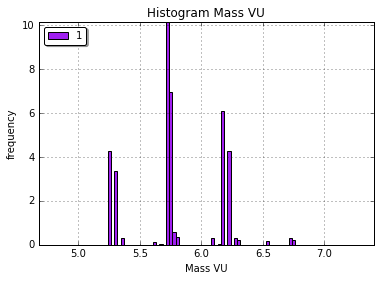

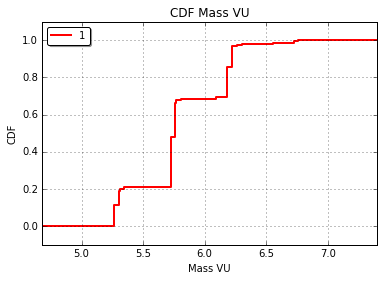

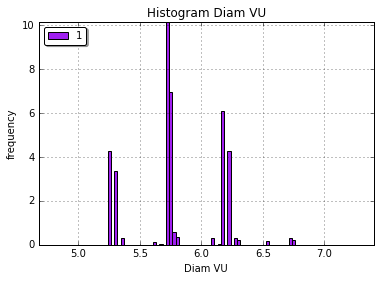

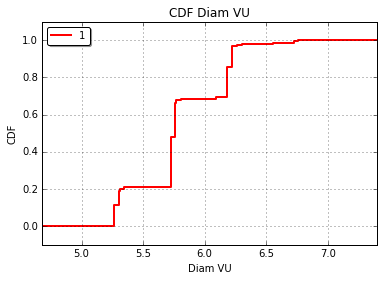

In [9]:
initMassVU = EWIS_func.CalcMassFunc([NbEqByVU, Conf['DeltaV']*Conf['V0']],(np.array(Dist_VU))[:,0],Catalog_Gauge)
modelMassVU = ot.NumericalMathFunction(initMassVU)

Y = modelMassVU(PowerSampleVU)
#Mass
MassSample_VU = Y.getMarginal (0)
MassVU_min = MassSample_VU.getMin()[0]
MassVU_max = MassSample_VU.getMax()[0]
fittedDist_Mass_VU = ot.KernelSmoothing().build(MassSample_VU)

viewResults(MassSample_VU, "Mass VU", MassVU_min-0.1, MassVU_max+0.1, Conf['Workdir'])

#Diameter
DiamSample_VU = Y.getMarginal (0)
DiamVU_min = DiamSample_VU.getMin()[0]
DiamVU_max = DiamSample_VU.getMax()[0]
fittedDist_Diam_VU = ot.KernelSmoothing().build(DiamSample_VU)

viewResults(DiamSample_VU, "Diam VU", DiamVU_min-0.1, DiamVU_max+0.1, Conf['Workdir'])


#### Compute Total Mass & Diameter 

-------------------------------------------------------------------------------
Mass TOT 

* ------ Deterministic analysis ------*
Mass TOT Min = 11.1543183721 Max =  22.7275605393 Delta =  11.5732421672


* ------ Probabilistic analysis ------*
Mass TOT Quantile @ 5% =  14.1287822568 Quantile @ 50% =  17.670429844 Quantile @ 95% =  20.7758836861
Mass TOT: Variance = 5.23672852538 6-sigma =  13.7303396503
Mass TOT: Interquantile (q(99,7%) - q(0,3%)) =  8.86398888774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Diam TOT 

* ------ Deterministic analysis ------*
Diam TOT Min = 16.9408393049 Max =  478.158324344 Delta =  461.217485039


* ------ Probabilistic analysis ------*
Diam TOT Quantile @ 5% =  18.4799542361 Quantile @ 50% =  161.579099359 Quantile @ 95% =  419.149091703
Diam TOT: Variance = 34704.2081477 6-sigma =  1117.74393012
Diam TOT: Interquantile (q(99,7%) - q(0

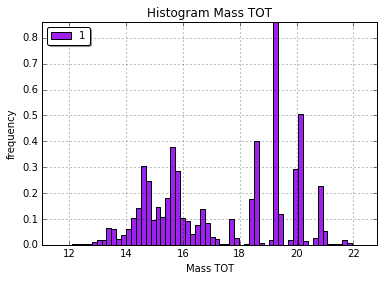

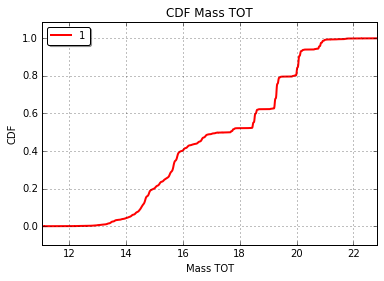

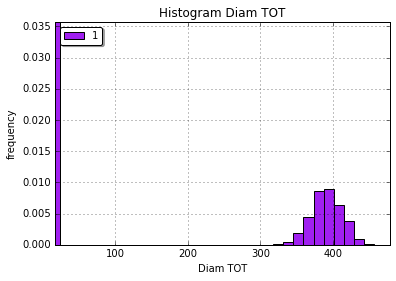

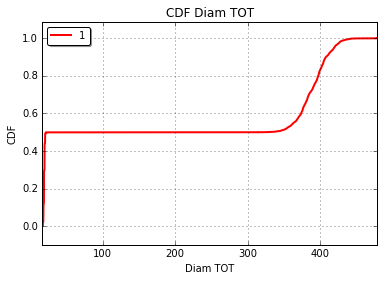

In [10]:
#- Compute Total Mass of EWIS Architecture (SPDB + VU) with correcting factors C1 & C2-#

Mass_TOT = ot.RandomMixture([Conf['C1']*Conf['C2']*fittedDist_Mass_SPDB, Conf['C1']*Conf['C2']*fittedDist_Mass_VU])
MassSample_TOT = Mass_TOT.getSample(sizeSample)
MassTOT_min = MassSample_TOT.getMin()[0]
MassTOT_max = MassSample_TOT.getMax()[0]

viewResults(MassSample_TOT, "Mass TOT", MassTOT_min-0.1, MassTOT_max+0.1, Conf['Workdir'])


Diam_TOT = ot.RandomMixture([Conf['C1']*Conf['C2']*fittedDist_Diam_SPDB, Conf['C1']*Conf['C2']*fittedDist_Diam_VU])
DiamSample_TOT = Diam_TOT.getSample(sizeSample)
DiamTOT_min = DiamSample_TOT.getMin()[0]
DiamTOT_max = DiamSample_TOT.getMax()[0]

viewResults(DiamSample_TOT, "Diam TOT", DiamTOT_min-0.1, DiamTOT_max+0.1, Conf['Workdir'])


In [11]:
Mass_TOT = ot.RandomMixture ([Conf['C1']*Conf['C2']*fittedDist_Mass_SPDB,Conf['C1']*Conf['C2']*fittedDist_Mass_VU ])

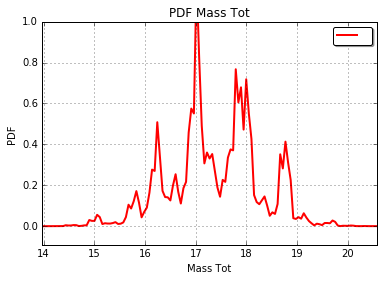

In [12]:
viewPDF (Mass_TOT, 'PDF Mass Tot', 'Mass Tot','PDF',' ',Conf['Workdir']+'/PDF Mass Tot.png')

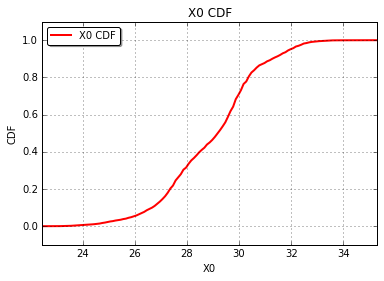

In [22]:
from openturns.viewer import View
View(A)

In [23]:
MassSample_TOT = Mass_TOT.getSample(20)
MassTOT_min = MassSample_TOT.getMin()[0]
MassTOT_max = MassSample_TOT.getMax()[0]

MassSample_TOT

class=NumericalSample name=Unnamed implementation=class=NumericalSampleImplementation name=Unnamed size=20 dimension=1 data=[[56.1971],[53.3585],[55.2301],[53.5644],[52.2812],[54.35],[57.3663],[54.972],[59.0939],[53.9052],[5.00806],[4.76331],[4.76264],[4.7558],[5.29188],[4.7053],[4.24967],[5.2938],[4.25628],[4.52387]]